In [1]:
#chack for updated files\n,
%load_ext autoreload
%autoreload 2
#import packages
from __future__ import division

import numpy as np
import glob, json
import pickle
import os as os_pack
import matplotlib.pyplot as plt
import corner
#%matplotlib inline\n",
%config InlineBackend.figure_format = 'retina'
import healpy as hp
import os, glob, json, pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as sl
import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const
from enterprise_extensions import blocks
from enterprise_extensions import models as ee_models
from enterprise_extensions import model_utils as ee_model_utils
from enterprise_extensions import model_orfs
from enterprise_extensions.frequentist import optimal_statistic as opt_stat
from enterprise_extensions import sampler as ee_sampler
from enterprise.signals.signal_base import LogLikelihood
import enterprise_wavelets as models
from enterprise.signals.deterministic_signals import Deterministic
from enterprise.signals.parameter import function
from la_forge.core import Core
from la_forge.diagnostics import plot_chains
from la_forge import rednoise
import la_forge
import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
import re
#style
    
#import Fast_Burst_likelihood as FB

In [2]:
#Loading in pickle and noise files
pint_pickle = '/home/reyna/OS_15yr/15yr_data/v1p1_de440_pint_bipm2019.pkl'
noise_file = '/home/reyna/OS_15yr/15yr_data/v1p1_wn_dict.json'
#psrlist = np.loadtxt('/home/reyna/15yr_v1p0/15yr_v1-20211001T235643Z-001/15yr_v1/psrlist_15yr_pint.txt', dtype = str)
with open(noise_file, 'r') as h:
    noise_params = json.load(h)
with open(pint_pickle,'rb') as f:
    allpsrs = pickle.load(f)
psrs = []
for ii,p in enumerate(allpsrs):
    psrs.append(p)
#Temporary to get code to not crash
psrs = psrs[0:]
psrlist = [psr.name for psr in psrs]
print(psrlist)
for i in range(len(psrs)):
    print((max(psrs[i].toas) - min(psrs[i].toas))/(3.17*10**(7)))

['B1855+09', 'B1937+21', 'B1953+29', 'J0023+0923', 'J0030+0451', 'J0340+4130', 'J0406+3039', 'J0437-4715', 'J0509+0856', 'J0557+1551', 'J0605+3757', 'J0610-2100', 'J0613-0200', 'J0636+5128', 'J0645+5158', 'J0709+0458', 'J0740+6620', 'J0931-1902', 'J1012+5307', 'J1012-4235', 'J1022+1001', 'J1024-0719', 'J1125+7819', 'J1312+0051', 'J1453+1902', 'J1455-3330', 'J1600-3053', 'J1614-2230', 'J1630+3734', 'J1640+2224', 'J1643-1224', 'J1705-1903', 'J1713+0747', 'J1719-1438', 'J1730-2304', 'J1738+0333', 'J1741+1351', 'J1744-1134', 'J1745+1017', 'J1747-4036', 'J1751-2857', 'J1802-2124', 'J1811-2405', 'J1832-0836', 'J1843-1113', 'J1853+1303', 'J1903+0327', 'J1909-3744', 'J1910+1256', 'J1911+1347', 'J1918-0642', 'J1923+2515', 'J1944+0907', 'J1946+3417', 'J2010-1323', 'J2017+0603', 'J2033+1734', 'J2043+1711', 'J2124-3358', 'J2145-0750', 'J2214+3000', 'J2229+2643', 'J2234+0611', 'J2234+0944', 'J2302+4442', 'J2317+1439', 'J2322+2057']
15.515060297068947
15.802872967471835
11.08458774068679
8.975425297

In [3]:
glitches = []
N_glitches = 5
for i in range(N_glitches):
    log10_f0 = parameter.Uniform(np.log10(3.5e-9), np.log10(1e-7))("Glitch_"+str(i)+'_'+'log10_f0')
    phase0 = parameter.Uniform(0, 2*np.pi)("Glitch_"+str(i)+'_'+'phase0')
    tau = parameter.Uniform(0.2, 5)("Glitch_"+str(i)+'_'+'tau')
    t0 = parameter.Uniform(0.0, 10.0)("Glitch_"+str(i)+'_'+'t0')
    psr_idx = parameter.Uniform(-0.5, len(psrs)-0.5)("Glitch_"+str(i)+'_'+'psr_idx')
    log10_h = parameter.LinearExp(-10.5, -9)("Glitch_"+str(i)+'_'+'log10_h')
    glitch_wf = models.glitch_delay(log10_h = log10_h, tau = tau, log10_f0 = log10_f0, t0 = t0, phase0 = phase0, tref=53000*86400,
                                            psr_float_idx = psr_idx, pulsars=psrs)
    glitches.append(deterministic_signals.Deterministic(glitch_wf, name='Glitch'+str(i) ))

In [4]:
#wavelet models
wavelets = [] #added "wavelet_" to names to help with seperation
N_wavelets = 5
for i in range(N_wavelets):
    log10_f0 = parameter.Uniform(np.log10(3.5e-9), np.log10(1e-7))("wavelet_"+str(i)+'_'+'log10_f0')
    cos_gwtheta = parameter.Uniform(-1, 1)("wavelet_"+str(i)+'_'+'cos_gwtheta')
    gwphi = parameter.Uniform(0, 2*np.pi)("wavelet_"+str(i)+'_'+'gwphi')
    psi = parameter.Uniform(0, np.pi)("wavelet_"+str(i)+'_'+'gw_psi')
    phase0 = parameter.Uniform(0, 2*np.pi)("wavelet_"+str(i)+'_'+'phase0')
    phase0_cross = parameter.Uniform(0, 2*np.pi)("wavelet_"+str(i)+'_'+'phase0_cross')
    tau = parameter.Uniform(0.2, 5)("wavelet_"+str(i)+'_'+'tau')
    t0 = parameter.Uniform(0.0, 10.0)("wavelet_"+str(i)+'_'+'t0')
    log10_h = parameter.LinearExp(-18,-11)("wavelet_"+str(i)+'_'+'log10_h')
    log10_h_cross = parameter.LinearExp(-18,-11)("wavelet_"+str(i)+'_'+'log10_h_cross')
    wavelet_wf = models.wavelet_delay(cos_gwtheta=cos_gwtheta, gwphi=gwphi, log10_h = log10_h, log10_h2=log10_h_cross,
                                      tau = tau, log10_f0 = log10_f0, t0 = t0, phase0 = phase0, phase02=phase0_cross,
                                      epsilon = None, psi=psi, tref=53000*86400)
    wavelets.append(deterministic_signals.Deterministic(wavelet_wf, name='wavelet'+str(i)))

In [5]:
tm = gp_signals.TimingModel(use_svd=True)
wn = blocks.white_noise_block(vary=False, inc_ecorr=False)
#s = base_model
s = tm + wn
for i in range(N_glitches):
    s += glitches[i]
for j in range(N_wavelets):
    s += wavelets[j]
model = []
for p in psrs:
    model.append(s(p))
with open(noise_file, 'r') as fp:
    noisedict = json.load(fp)
    pta = signal_base.PTA(model)
    pta.set_default_params(noisedict)

In [21]:
d0_15y = parameter.sample(pta.params)
x0_15y = np.array([d0_15y[par.name] for par in pta.params])

In [22]:
pta.get_lnlikelihood(x0_15y)

7575421.64972458

In [13]:
np.exp(7575421.709587448 - 7575421.709587448) #single 15y multi test

1.0

In [8]:
d0_15y;

In [23]:
xSorted_15y = [[],[],[],[],[],[]]
for i in range(N_glitches):
    xSorted_15y[0].append(10**(d0_15y['Glitch_'+str(i)+'_log10_f0']))
    xSorted_15y[1].append(10**(d0_15y['Glitch_'+str(i)+'_log10_h']))
    xSorted_15y[2].append(d0_15y['Glitch_'+str(i)+'_phase0'])
    xSorted_15y[3].append(d0_15y['Glitch_'+str(i)+'_psr_idx'])
    xSorted_15y[4].append((365.25*24*3600)*(d0_15y['Glitch_'+str(i)+'_t0']))
    xSorted_15y[5].append((365.25*24*3600)*(d0_15y['Glitch_'+str(i)+'_tau']))
xSort_wave_15y = [[],[],[],[],[],[],[],[],[],[]]
for i in range(N_wavelets):
    xSort_wave_15y[0].append(10**(d0_15y['wavelet_'+str(i)+'_log10_f0']))
    xSort_wave_15y[1].append(np.arccos(d0_15y['wavelet_'+str(i)+'_cos_gwtheta']))
    xSort_wave_15y[2].append(d0_15y['wavelet_'+str(i)+'_gwphi'])
    xSort_wave_15y[3].append(d0_15y['wavelet_'+str(i)+'_gw_psi'])
    xSort_wave_15y[4].append(d0_15y['wavelet_'+str(i)+'_phase0'])
    xSort_wave_15y[5].append(d0_15y['wavelet_'+str(i)+'_phase0_cross'])
    xSort_wave_15y[6].append((365.25*24*3600)*d0_15y['wavelet_'+str(i)+'_tau'])
    xSort_wave_15y[7].append((365.25*24*3600)*d0_15y['wavelet_'+str(i)+'_t0'])
    xSort_wave_15y[8].append(10**(d0_15y['wavelet_'+str(i)+'_log10_h']))
    xSort_wave_15y[9].append(10**(d0_15y['wavelet_'+str(i)+'_log10_h_cross']))

In [24]:
import Fast_Burst_likelihood as FB

In [25]:
FB_15y = FB.FastBurst(pta = pta, psrs = psrs, params = d0_15y, Npsr = len(psrs), tref=53000*86400, Nglitch = N_glitches, Nwavelet = N_wavelets)

In [27]:
%%prun
FB_15y.get_lnlikelihood(xSorted_15y[1], xSorted_15y[2], xSorted_15y[0], xSorted_15y[5], xSorted_15y[4], xSorted_15y[3],xSort_wave_15y[1],
                    xSort_wave_15y[2],xSort_wave_15y[8],xSort_wave_15y[9],xSort_wave_15y[4],xSort_wave_15y[5],xSort_wave_15y[3],xSort_wave_15y[0],xSort_wave_15y[6],xSort_wave_15y[7])

In [17]:
NN = 20

log_L_Ent_15y = []
log_L_Fast_15y = []
#amplitudes = []

for n in range(NN):
    #amplitudes.append(i*0.5e-6)
    d0_15y = parameter.sample(pta.params)
    x0_15y = np.array([d0_15y[par.name] for par in pta.params])
    
    xSorted_15y = [[],[],[],[],[],[]]
    for i in range(N_glitches):
        xSorted_15y[0].append(10**(d0_15y['Glitch_'+str(i)+'_log10_f0']))
        xSorted_15y[1].append(10**(d0_15y['Glitch_'+str(i)+'_log10_h']))
        xSorted_15y[2].append(d0_15y['Glitch_'+str(i)+'_phase0'])
        xSorted_15y[3].append(d0_15y['Glitch_'+str(i)+'_psr_idx'])
        xSorted_15y[4].append((365.25*24*3600)*(d0_15y['Glitch_'+str(i)+'_t0']))
        xSorted_15y[5].append((365.25*24*3600)*(d0_15y['Glitch_'+str(i)+'_tau']))
    xSort_wave_15y = [[],[],[],[],[],[],[],[],[],[]]
    for j in range(N_wavelets):
        xSort_wave_15y[0].append(10**(d0_15y['wavelet_'+str(j)+'_log10_f0']))
        xSort_wave_15y[1].append(np.arccos(d0_15y['wavelet_'+str(j)+'_cos_gwtheta']))
        xSort_wave_15y[2].append(d0_15y['wavelet_'+str(j)+'_gwphi'])
        xSort_wave_15y[3].append(d0_15y['wavelet_'+str(j)+'_gw_psi'])
        xSort_wave_15y[4].append(d0_15y['wavelet_'+str(j)+'_phase0'])
        xSort_wave_15y[5].append(d0_15y['wavelet_'+str(j)+'_phase0_cross'])
        xSort_wave_15y[6].append((365.25*24*3600)*d0_15y['wavelet_'+str(j)+'_tau'])
        xSort_wave_15y[7].append((365.25*24*3600)*d0_15y['wavelet_'+str(j)+'_t0'])
        xSort_wave_15y[8].append(10**(d0_15y['wavelet_'+str(j)+'_log10_h']))
        xSort_wave_15y[9].append(10**(d0_15y['wavelet_'+str(j)+'_log10_h_cross']))

    
    log_L_Ent_15y.append(pta.get_lnlikelihood(x0_15y))
    log_L_Fast_15y.append(FB_15y.get_lnlikelihood(xSorted_15y[1], xSorted_15y[2], xSorted_15y[0], xSorted_15y[5], xSorted_15y[4], xSorted_15y[3],xSort_wave_15y[1],
                    xSort_wave_15y[2],xSort_wave_15y[8],xSort_wave_15y[9],xSort_wave_15y[4],xSort_wave_15y[5],xSort_wave_15y[3],xSort_wave_15y[0],xSort_wave_15y[6],xSort_wave_15y[7]))
    print('run ',n)
    
log_L_Ent_15y = np.array(log_L_Ent_15y_amp)
log_L_Fast_15y = np.array(log_L_Fast_15y_amp)

run  0
run  1
run  2
run  3
run  4
run  5
run  6
run  7
run  8
run  9
run  10
run  11
run  12
run  13
run  14
run  15
run  16
run  17
run  18
run  19


NameError: name 'log_L_Ent_15y_amp' is not defined

In [18]:
log_L_Ent_15y = np.array(log_L_Ent_15y)
log_L_Fast_15y = np.array(log_L_Fast_15y)

Text(0.5, 1.0, 'lnlikelihood comparisons FullFB 15y dataset')

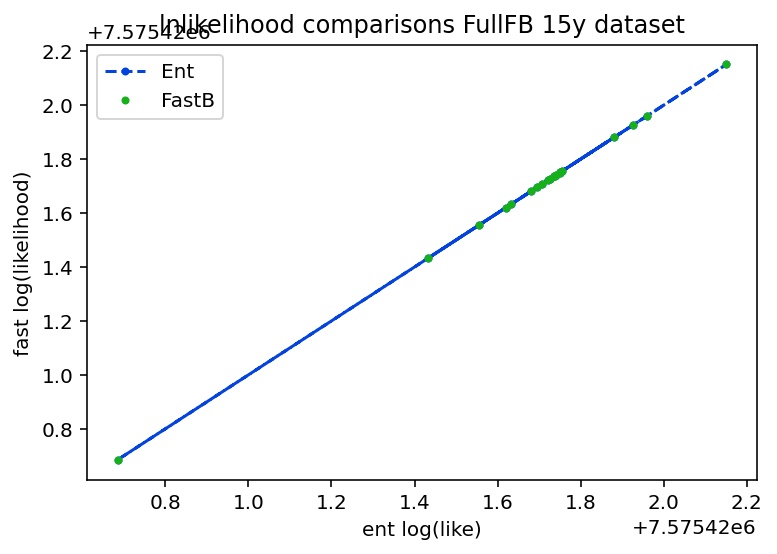

In [19]:
plt.plot(log_L_Ent_15y, log_L_Ent_15y, ls='--', marker='.', color='xkcd:blue', label = 'Ent')
plt.plot(log_L_Ent_15y, log_L_Fast_15y, ls='', marker='.', color='xkcd:green', label = 'FastB')
plt.legend(loc='upper left')
plt.xlabel("ent log(like)")
plt.ylabel("fast log(likelihood)")
plt.title('lnlikelihood comparisons FullFB 15y dataset')
#plt.savefig('/home/reyna/BayesHopperBurst/testing plots/FullFastBurst_15y_lnlikedif.png')

Text(0.5, 1.0, 'val dif for randome samples 15y')

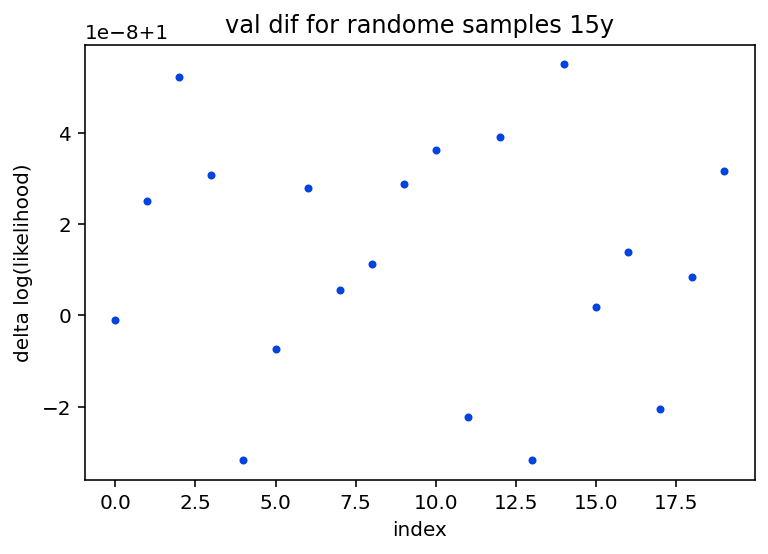

In [20]:
plt.plot(np.exp(log_L_Fast_15y - log_L_Ent_15y), ls='', marker='.', color='xkcd:blue')
#plt.gca().axhline(0.1, ls='--', color='xkcd:green')
plt.xlabel("index")
plt.ylabel("delta log(likelihood)")
plt.title('val dif for randome samples 15y')
#plt.savefig('/home/reyna/BayesHopperBurst/testing plots/FullFastBurst_15y_precentdif.png')

In [668]:
NN = 20
xSorted_15y = np.zeros((NN,6,N_glitches))
xSort_wave_15y = np.zeros((NN,10,N_wavelets))
d0_15y = []
x0_15y = []

for i in range(NN):
    d0_15y.append(parameter.sample(pta.params))
    d0_15ytemp = parameter.sample(pta.params)
    x0_15y.append(([d0_15ytemp[par.name] for par in pta.params]))
    
    for k in range(N_glitches):
        xSorted_15y[i,0,k]=(10**(d0_15y[i]['Glitch_'+str(k)+'_log10_f0']))
        xSorted_15y[i,1,k]=(10**(d0_15y[i]['Glitch_'+str(k)+'_log10_h']))
        xSorted_15y[i,2,k]=(d0_15y[i]['Glitch_'+str(k)+'_phase0'])
        xSorted_15y[i,3,k]=(d0_15y[i]['Glitch_'+str(k)+'_psr_idx'])
        xSorted_15y[i,4,k]=((365.25*24*3600)*(d0_15y[i]['Glitch_'+str(k)+'_t0']))
        xSorted_15y[i,5,k]=((365.25*24*3600)*(d0_15y[i]['Glitch_'+str(k)+'_tau']))
    for j in range(N_wavelets):
        xSort_wave_15y[i,0,j]=(10**(d0_15y[i]['wavelet_'+str(j)+'_log10_f0']))
        xSort_wave_15y[i,1,j]=(np.arccos(d0_15y[i]['wavelet_'+str(j)+'_cos_gwtheta']))
        xSort_wave_15y[i,2,j]=(d0_15y[i]['wavelet_'+str(j)+'_gwphi'])
        xSort_wave_15y[i,3,j]=(d0_15y[i]['wavelet_'+str(j)+'_gw_psi'])
        xSort_wave_15y[i,4,j]=(d0_15y[i]['wavelet_'+str(j)+'_phase0'])
        xSort_wave_15y[i,5,j]=(d0_15y[i]['wavelet_'+str(j)+'_phase0_cross'])
        xSort_wave_15y[i,6,j]=((365.25*24*3600)*d0_15y[i]['wavelet_'+str(j)+'_tau'])
        xSort_wave_15y[i,7,j]=((365.25*24*3600)*d0_15y[i]['wavelet_'+str(j)+'_t0'])
        xSort_wave_15y[i,8,j]=(10**(d0_15y[i]['wavelet_'+str(j)+'_log10_h']))
        xSort_wave_15y[i,9,j]=(10**(d0_15y[i]['wavelet_'+str(j)+'_log10_h_cross']))

In [669]:
NN = 20

log_L_Ent_15y = []
log_L_Fast_15y = []

for i in range(NN):
    
    log_L_Ent_15y.append(pta.get_lnlikelihood(x0_15y[i]))
    print('ent ',i)
    log_L_Fast_15y.append(FB_15y.get_lnlikelihood(xSorted_15y[i,1], xSorted_15y[i,2], xSorted_15y[i,0], xSorted_15y[i,5], xSorted_15y[i,4], xSorted_15y[i,3],xSort_wave_15y[i,1],
                    xSort_wave_15y[i,2],xSort_wave_15y[i,8],xSort_wave_15y[i,9],xSort_wave_15y[i,4],xSort_wave_15y[i,5],xSort_wave_15y[i,3],xSort_wave_15y[i,0],xSort_wave_15y[i,6],xSort_wave_15y[i,7]))
    print('run ',i)
    
log_L_Ent_15y = np.array(log_L_Ent_15y)
log_L_Fast_15y = np.array(log_L_Fast_15y)

ent  0
run  0
ent  1
run  1
ent  2
run  2
ent  3
run  3
ent  4
run  4
ent  5
run  5
ent  6
run  6
ent  7
run  7
ent  8
run  8
ent  9
run  9
ent  10
run  10
ent  11
run  11
ent  12
run  12
ent  13
run  13
ent  14
run  14
ent  15
run  15
ent  16
run  16
ent  17
run  17
ent  18
run  18
ent  19
run  19


Text(0.5, 1.0, 'lnlikelihood comparisons FullFB 15y dataset')

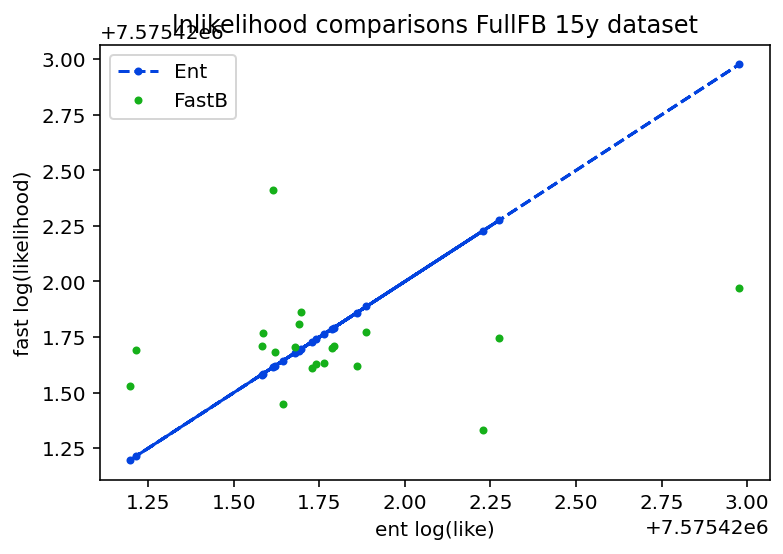

In [670]:
plt.plot(log_L_Ent_15y, log_L_Ent_15y, ls='--', marker='.', color='xkcd:blue', label = 'Ent')
plt.plot(log_L_Ent_15y, log_L_Fast_15y, ls='', marker='.', color='xkcd:green', label = 'FastB')
plt.legend(loc='upper left')
plt.xlabel("ent log(like)")
plt.ylabel("fast log(likelihood)")
plt.title('lnlikelihood comparisons FullFB 15y dataset')
#plt.savefig('/home/reyna/BayesHopperBurst/testing plots/FullFastBurst_15y_lnlikedif.png')

Text(0.5, 1.0, 'val dif for randome samples 15y')

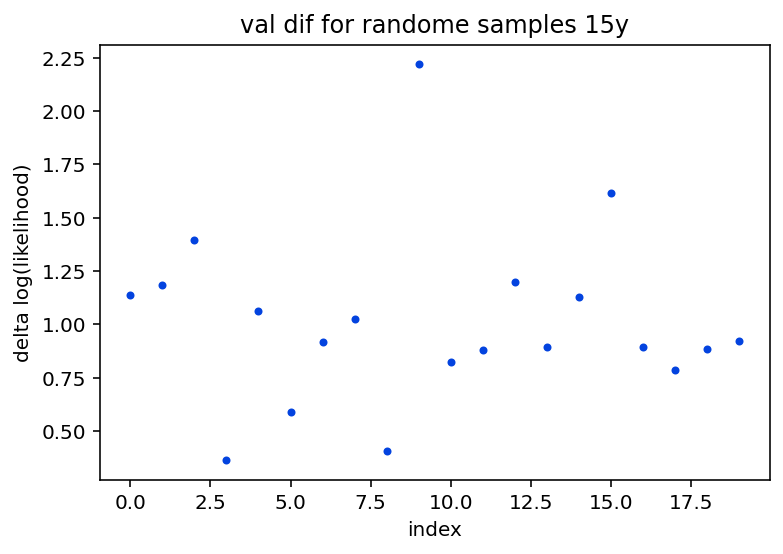

In [671]:
plt.plot(np.exp(log_L_Fast_15y - log_L_Ent_15y), ls='', marker='.', color='xkcd:blue')
#plt.gca().axhline(0.1, ls='--', color='xkcd:green')
plt.xlabel("index")
plt.ylabel("delta log(likelihood)")
plt.title('val dif for randome samples 15y')
#plt.savefig('/home/reyna/BayesHopperBurst/testing plots/FullFastBurst_15y_precentdif.png')

Text(0.5, 1.0, '%dif for randome samples 15y')

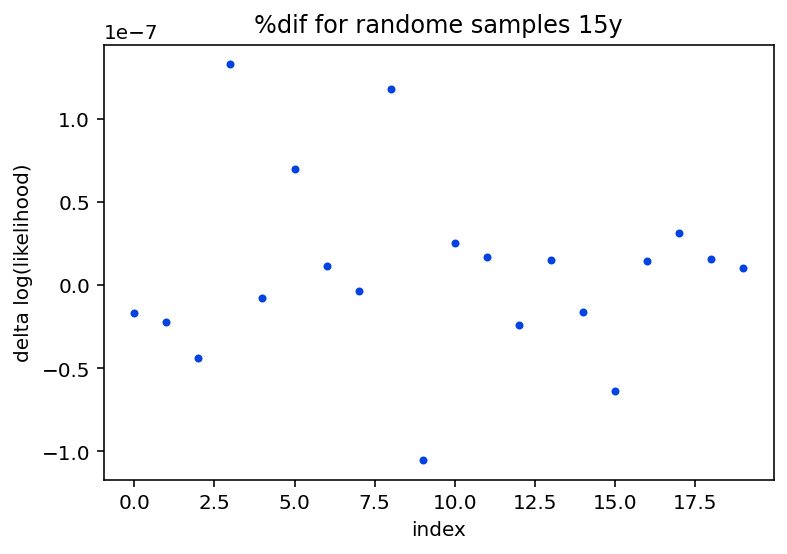

In [672]:
plt.plot(log_L_Ent_15y/log_L_Fast_15y - 1, ls='', marker='.', color='xkcd:blue')
#plt.gca().axhline(0.1, ls='--', color='xkcd:green')
plt.xlabel("index")
plt.ylabel("delta log(likelihood)")
plt.title('%dif for randome samples 15y')
#plt.savefig('/home/reyna/BayesHopperBurst/testing plots/FullFastBurst_15y_precentdif.png')